
## Volume 2: OpenGym



<Name\>Brian James
<Class\>
<Date\>





**Note:** Some IPython notebook platforms (such as Google Colab) do not currently support rendering OpenAI environments. In order to properly render the OpenGym environments in this lab, you may need to run the Jupyter Notebook locally (for example, run it in VSCode or from the command line).

In [2]:
import gym
import numpy as np
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt

**Problem 1**

*   Implement `random_blackjack()`.
*   Run the game 500 times and output the percentage of games that are wins.



In [77]:
# Problem 1
def random_blackjack(n):
    """
    Play a random game of Blackjack. Determine the
    percentage the player wins out of n times.
    Parameters:
        n (int): number of iterations
    Returns:
        percent (float): percentage that the player
                         wins
    """
    env = gym.make("Blackjack-v1")
    playerWins = 0
    for i in range(n):
        
        observation = env.reset()    # deal hand of 2 cards
        observation, reward, done, info = env.step(env.action_space.sample())   # randomly choose between holding or drawing another card
        
        while not done:
            observation, reward, done, info = env.step(env.action_space.sample())
        
        if reward == 1:
            playerWins += 1
            
    return playerWins / n

In [78]:
# Run the game here
random_blackjack(500)

0.25

**Problem 2**

* Implement `blackjack()`.
* For `n` = 1, 2, ..., 21, plot the win percentage after 10,000 games of Blackjack.
* Identify which value of `n` gives the highest win rate.

In [93]:
# Problem 2
def blackjack(n=11):
    """
    Play blackjack with naive algorithm.
    Parameters:
        n (int): maximum accepted player hand
    Return:
        percent (float): percentage of 10000 iterations
                         that the player wins
    """
    game = gym.make("Blackjack-v1")
    total = 0
    for _ in range(10000):
        observation = game.reset()    # draw a starting hand of two cards
        handSize = 2
        done = False
        while handSize <= n and not done:
            observation, reward, done, info = game.step(1) # 1 means draw a new card
            handSize += 1
            
        if not done:     # if player hasn't already lost, stay your hand.
            observation, reward, done, info = game.step(0)
            
        if reward > 0:
            total += reward
        
    
    return total / 10000
    
    # QUESTION: what is defined as a hand? How can you have a hand size of 1? Do you draw more than the max size?
    # The text suggest you draw max hand size +1 cards

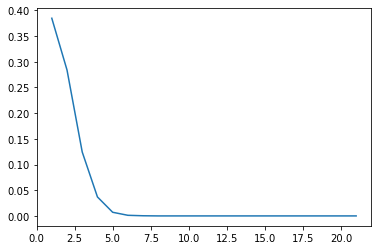

In [108]:
# Plot here
nspace = np.arange(1,22)
winrates = []
for n in nspace:
    winrates.append(blackjack(n))
    
plt.plot(nspace,winrates)
plt.show()

*Identify which value(s) give the highest winrate here*
The highest winrate is when n=1. Honestly I don't know how this makes sense since your handsize is always a minimum of 2, unless hand is defined differently according to this lab.

**Problem 3**

* Implement `cartpole()`.
* Render the game and run your function once.
* Run Cartpole 100 times (without rendering) and print out the average number of steps before it terminates.

In [75]:
# Problem 3
def cartpole(render=False):
    """
    Solve CartPole-v0 by checking the velocity
    of the tip of the pole.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of steps or iterations
                              to solve the environment
    """
    
    env = gym.make('CartPole-v1')
    observation = env.reset()
    for i in range(1000):
        if render:
            env.render()
        if observation[3] <= 0:
            observation, reward, done, info = env.step(0)
        elif observation[3] > 0:
            observation, reward, done, info = env.step(1)
        if done:
            break
    if render:
        env.render()
        env.reset()
        env.close()
    return i+1

In [ ]:
# Render the game and run once here
cartpole(True)

In [76]:
# Run the game here and print average steps to termination
total = 0
for _ in range(100):
    total += cartpole()
print("Average steps to termination: " + str(total/100))

Average steps to termination: 205.02


**Problem 4**

* Implement `car()`.
* Render the game and run your function once.
* Run MountainCar 100 times (without rendering) and print out the average number of steps before it terminates.

In [69]:
# Problem 4
def car(render=False):
    """
    Solve MountainCar-v0 by checking the position
    of the car.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of steps or iterations
                              to solve the environment
    """
    env = gym.make('MountainCar-v0')
    
    observation = env.reset()
    observation, reward, done, info = env.step(2)
    numSteps = 0
    while observation[0] < .5 and not done:
        if render:
            env.render()
        if observation[0] and observation[1] <= 0:    # going up the left hill. --> accelerate left
            observation, reward, done, info = env.step(0)
        elif observation[0] <= 0 and observation[1] > 0:    # going down the left hill --> accelerate right
            observation, reward, done, info = env.step(2)
        elif observation[0] > 0 and observation[1] <=0:   # going down the right hill --> accelerate left
            observation, reward, done, info = env.step(0)
        elif observation[0] > 0 and observation[1] > 0:   # going up the left hill --> accelerate right
            observation, reward, done, info = env.step(2)
        numSteps += 1
    if render:
        env.render()
        env.reset()
        env.close()
            
    return numSteps

In [70]:
# Render the game here
car(True)

120

In [72]:
# Run the game here and print average steps to termination
total = 0 
for _ in range(100):
    total += car()
    
print("Average steps to termination: " + str(total/100))

Average steps to termination: 118.14


**Helper Function for Problem 5**

In [16]:
def find_qvalues(env,alpha=.1,gamma=.6,epsilon=.1):
    """
    Use the Q-learning algorithm to find qvalues.
    Parameters:
        env (str): environment name
        alpha (float): learning rate
        gamma (float): discount factor
        epsilon (float): maximum value
    Returns:
        q_table (ndarray nxm)
    """
    # Make environment
    env = gym.make(env)
    # Make Q-table
    q_table = np.zeros((env.observation_space.n,env.action_space.n))

    # Train
    for i in range(1,100001):
        # Reset state
        state = env.reset()

        epochs, penalties, reward, = 0,0,0
        done = False

        while not done:
            # Accept based on alpha
            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])

            # Take action
            next_state, reward, done, info = env.step(action)

            # Calculate new qvalue
            old_value = q_table[state,action]
            next_max = np.max(q_table[next_state])

            new_value = (1-alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            # Check if penalty is made
            if reward == -10:
                penalties += 1

            # Get next observation
            state = next_state
            epochs += 1

        # Print episode number
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.")
    return q_table


**Problem 5**

* Render the "`Taxi-v3`" environment, act randomly until it terminates, and calculate the total reward
* Render the "`Taxi-v3`" environment, use the Q-table to act optimally until it terminates, and calculate the total reward
* Implement `taxi()`, then use it to print the average total reward for each algorithm.


In [25]:
# Random actions Taxi game
env = gym.make('Taxi-v3')
totReward = 0
done = False
env.reset()
while not done:
    observation, reward, done, info = env.step(env.action_space.sample())
    totReward += reward
print(totReward)

-749


In [27]:
# Q-table actions Taxi game
q_table = find_qvalues('Taxi-v3')

Episode: 100000
Training finished.


In [66]:
def taxi(q_table):
    """
    Compare naive and q-learning algorithms.
    Parameters:
        q_table (ndarray nxm): table of qvalues
    Returns:
        naive (float): mean reward of naive algorithm
                       of 10000 runs
        q_reward (float): mean reward of Q-learning algorithm
                          of 10000 runs
    """
    # Naive taxi
    naiveEnv = gym.make('Taxi-v3')
    naiveTotal = 0
    
    #Q-table taxi
    qTableEnv = gym.make('Taxi-v3')
    qTableTotal = 0

    for i in range(10000):
        naiveObservation = naiveEnv.reset()
        naiveDone = False
        
        qTableObservation = qTableEnv.reset()
        qTableDone = False
        
        while not naiveDone:
            observation, reward, naiveDone, info = naiveEnv.step(naiveEnv.action_space.sample())
            naiveTotal += reward

        while not qTableDone:
            bestAction = np.argmax(q_table[qTableObservation])
            qTableObservation, reward, qTableDone, info = qTableEnv.step(bestAction)
            qTableTotal += reward
    
    return naiveTotal / 10000, qTableTotal / 10000

In [67]:
# Print the average rewards of the Taxi game for both algorithms run 10,000 times
taxi(q_table)

(-768.8476, 7.9444)